# Pneumonia Localization Using Heat Maps of Class Activation

In this notebook, we provide the source code of localizing pneumonia using heat maps.
Here we use the implementation of the work in "Grad-CAM: Visual
Explanations from Deep Networks via Gradient-based Localization.[1]"

[1] Ramprasaath R. Selvaraju et al., arXiv (2017), https://arxiv.org/abs/1610.02391.

In [1]:
# Loading libraries
import numpy as np
from keras import models
from keras.applications.vgg16 import VGG16
from keras import layers
from keras.preprocessing import image
from keras import backend as K
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Loading the trained model

In [2]:
# First, build the model
img_width = 220
img_height = 220
img_channels = 3
weights='imagenet'
img_dim = (img_width, img_height, img_channels)

base_model = VGG16(
              weights=weights,
              include_top=False,
              input_shape=img_dim)

model = models.Sequential()

i=0
for layer in base_model.layers:
    layer.trainable = False
    model.add(layer)
    i+=1
    if(i>6):
        break


model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 220, 220, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 220, 220, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 110, 110, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 110, 110, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 110, 110, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 55, 55, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 128)      

In [3]:
# Secound, load the trained weights
model.load_weights('Checkpoints/model.hdf5')

## Loading and  preprocessing the image to be diagnosed

In [15]:
img_path = './HeatMap//1.jpeg'
img = image.load_img(img_path, target_size=(220, 220))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) # Adds a dimension to transform the array into a batch of size (1, 220, 220, 3)
x /=255.

In [16]:
# Classify/Diagnose the image
preds = model.predict(x)
print('Negative probability: ', preds[0][0], ' || Positive probability: ', preds[0][1])

Negative probability:  0.00014787173  || Positive probability:  0.99985206


## Setting up the Grad-CAM algorithm

In [22]:
positive_pneumonia_output = model.output[:, 1]
last_conv_layer = model.get_layer('conv2d_2') #Output feature map of the conv2d_2 layer

# Gradient of the “Positive pneumonia” class with regard to the output feature map of conv2d_2
grads = K.gradients(positive_pneumonia_output, last_conv_layer.output)[0]

# Vector of shape (128,), where each entry is the mean intensity of the gradient over a specific feature-map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Lets you access the values of the quantities you just defined: pooled_grads and the output feature map of conv2d_2, given
# a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# Values of these two quantities, as Numpy arrays, given the sample input image x
pooled_grads_value, conv_layer_output_value = iterate([x])

# Multiplies each channel in the feature-map array by “how important this channel is” with regard to the “pneumonia” class
for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map is the heatmap of the class activation.
heatmap = np.mean(conv_layer_output_value, axis=-1)

(None, 10, 10, 128)


## Heatmap post-processing

For visualization purposes, we’ll need to normalize the heatmap between 0 and 1.

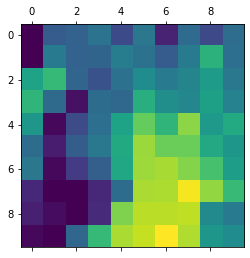

In [18]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

## Superimposing the heatmap with the original picture

In [19]:

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap) # Converts the heatmap to RGB
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img #0.4 here is a heatmap intensity factor.
cv2.imwrite('./HeatMap/rr_cam.jpg', superimposed_img)

True